# K-Day User Constraint for Weather Data Generation 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import random
import scipy
from scipy.stats import chisquare
from collections import Counter

## Load Data

In [3]:
data_raw = pd.read_csv('data/data-2010-2024.csv', delimiter=",", skiprows=3)
data_test = pd.read_csv('data/om-2025-test.csv', delimiter=",", skiprows=3 )

In [ ]:
weather_columns = {
    'temperature_2m (°C)': 'temp',
    'weather_code (wmo code)': 'weather_code',
    'precipitation (mm)': 'precip',
    'cloud_cover (%)': 'cloud_cover',
    'wind_speed_10m (km/h)': 'wind_speed',
    'sunshine_duration (s)': 'sunshine',    
}

def rename_columns(df):
    df.rename(columns=weather_columns, inplace=True)
    return df

def add_time_columns(df):
    constant_year = 2000
    df['time'] = pd.to_datetime(df['time'], errors='coerce')  # Handle parsing errors
    df = df.dropna(subset=['time'])  # Drop rows with invalid dates
    df['month'] = df['time'].dt.month
    df['day'] = df['time'].dt.day
    df['year'] = df['time'].dt.year
    df['minute'] = df['time'].dt.minute
    df['second'] = df['time'].dt.second
    df['hour'] = df['time'].dt.hour
    df['month_day_time'] = pd.to_datetime(
        df['month'].astype(str) + '-' +
        df['day'].astype(str) + '-' +
        str(constant_year) + ' ' +
        df['hour'].astype(str).str.zfill(2) + ':' +
        df['minute'].astype(str).str.zfill(2) + ':' +
        df['second'].astype(str).str.zfill(2),
        format='%m-%d-%Y %H:%M:%S'
    )
    return df

In [5]:
data_test['time'] = pd.to_datetime(data_test['time'], format='%Y-%m-%dT%H:%M', errors='coerce')
data_raw['time'] = pd.to_datetime(data_raw['time'], format='%Y-%m-%dT%H:%M', errors='coerce')
all_data = rename_columns(data_raw)
all_data = add_time_columns(all_data)
test_data = rename_columns(data_test)
test_data = add_time_columns(test_data)

/var/folders/8s/z9nb_fz50j39t__ftkhgz5pc0000gn/T/ipykernel_60107/1286158716.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['time'].dt.month
/var/folders/8s/z9nb_fz50j39t__ftkhgz5pc0000gn/T/ipykernel_60107/1286158716.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df['time'].dt.day
/var/folders/8s/z9nb_fz50j39t__ftkhgz5pc0000gn/T/ipykernel_60107/1286158716.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [6]:
test_data['temp'] = pd.to_numeric(test_data['temp'], errors='coerce')
test_data['sunshine'] = pd.to_numeric(test_data['sunshine'], errors='coerce')

/var/folders/8s/z9nb_fz50j39t__ftkhgz5pc0000gn/T/ipykernel_60107/223361395.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['temp'] = pd.to_numeric(test_data['temp'], errors='coerce')
/var/folders/8s/z9nb_fz50j39t__ftkhgz5pc0000gn/T/ipykernel_60107/223361395.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['sunshine'] = pd.to_numeric(test_data['sunshine'], errors='coerce')


## Categorize Weather Variables

In [7]:
## Average the data
daily_mean_df = all_data.groupby(['year', 'month', 'day']).mean().reset_index()
daily_mean_test_df = test_data.select_dtypes(include=[np.number]).groupby(['year', 'month', 'day']).mean().reset_index()

In [8]:
# Calculate Monthly Percentiles

def calculate_percentiles_and_categorize(df, month):
    """
    Calculates percentiles for a specific month and categorizes weather variables into low, medium, and high.
    Includes zero precipitation values in the "Low" category.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing weather data.
        month (int): The month for which to calculate percentiles (1 = January, ..., 12 = December).

    Returns:
        pd.DataFrame: A new DataFrame with additional columns for categorized weather variables.
    """
    # Filter data for the specified month
    month_data = df[df['month'] == month].copy()

    # Calculate percentiles for each weather variable
    thresholds = {}
    for variable in ['temp', 'precip', 'cloud_cover', 'wind_speed', 'sunshine']:
        variable_data = month_data[variable].dropna()

        if variable == 'precip':
            # Include zero values in the "Low" category
            low = np.percentile(variable_data, 33)
            high = np.percentile(variable_data, 66)
            thresholds[variable] = {'low': low, 'high': high}
        else:
            # Standard percentile calculation
            low = np.percentile(variable_data, 33)
            high = np.percentile(variable_data, 66)
            thresholds[variable] = {'low': low, 'high': high}

    # Categorize each variable based on the calculated thresholds
    for variable in thresholds.keys():
        low, high = thresholds[variable]['low'], thresholds[variable]['high']
        month_data[f'{variable}_category'] = month_data[variable].apply(
            lambda x: 'Low' if x <= low else 'Medium' if x < high else 'High'
        )

    return month_data

In [9]:
df_states1 = calculate_percentiles_and_categorize(daily_mean_df, 1)
df_states1_test = calculate_percentiles_and_categorize(daily_mean_test_df, 1)

In [10]:
# combine categories to make a weather state with temperature and precipitation
df_states1['state1'] = df_states1[['temp_category', 'precip_category']].agg('-'.join, axis=1)
df_states1_test['state1_test'] = df_states1_test[['temp_category', 'precip_category']].agg('-'.join, axis=1)

## Transition Matrix 

In [11]:
df = df_states1[['state1']].copy()
df_test = df_states1_test[['state1_test']].copy()
# Define the next state
df['next_state'] = df['state1'].shift(-1)
# Drop the last row since it has no next state
df = df.dropna(subset=['next_state'])
# Create a transition matrix with raw counts
transition_counts = pd.crosstab(df['state1'], df['next_state'])
# Normalize the transition counts to calculate probabilities
transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0)
# Fill NaN values with 0 (in case some rows have no transitions)
transition_matrix = transition_matrix.fillna(0)
print(transition_matrix)

next_state     High-High  High-Low  High-Medium  Low-High   Low-Low  \
state1                                                                
High-High       0.439560  0.065934     0.197802  0.000000  0.000000   
High-Low        0.333333  0.250000     0.291667  0.000000  0.000000   
High-Medium     0.380952  0.095238     0.190476  0.000000  0.000000   
Low-High        0.000000  0.035714     0.000000  0.178571  0.250000   
Low-Low         0.033333  0.011111     0.011111  0.111111  0.577778   
Low-Medium      0.027778  0.055556     0.027778  0.138889  0.472222   
Medium-High     0.142857  0.000000     0.040816  0.102041  0.061224   
Medium-Low      0.181818  0.045455     0.068182  0.000000  0.159091   
Medium-Medium   0.133333  0.050000     0.033333  0.050000  0.050000   

next_state     Low-Medium  Medium-High  Medium-Low  Medium-Medium  
state1                                                             
High-High        0.021978     0.087912    0.043956       0.142857  
High-Low      

## Add values for each category 

In [ ]:
def values_list(df, weather_var, category, weather_cat): 
    '''Creates a list of values for each weather variable for each category'''
    cat_rows = df.loc[df[weather_cat] == category]
    val_list = cat_rows[weather_var].to_list() 
    v_list = [ '%.1f' % elem for elem in val_list ]
    return v_list

In [13]:
# get low, med, high temperatures of january for further implementation
temp_low1 = values_list(df_states1, 'temp', 'Low', 'temp_category')
temp_med1 = values_list(df_states1, 'temp', 'Medium', 'temp_category')
temp_high1 = values_list(df_states1, 'temp', 'High', 'temp_category')

# get low, med, high precipitation of january for further implementation
prec_low1 = values_list(df_states1, 'precip', 'Low', 'precip_category')
prec_med1 = values_list(df_states1, 'precip', 'Medium', 'precip_category')
prec_high1 = values_list(df_states1, 'precip', 'High', 'precip_category')

all_temp = temp_low1 + temp_med1 + temp_high1

In [14]:
from scipy.stats import norm, gamma

temp_low1 = [float(x) for x in temp_low1]
temp_med1 = [float(x) for x in temp_med1]
temp_high1 = [float(x) for x in temp_high1]

prec_low1 = [float(x) for x in prec_low1]
prec_med1 = [float(x) for x in prec_med1]
prec_high1 = [float(x) for x in prec_high1]
# Example: fit temperature distributions
temp_low_params = norm.fit(temp_low1)  # returns mean and std
temp_med_params = norm.fit(temp_med1)
temp_high_params = norm.fit(temp_high1)

## Markov Chain Implementation

In [16]:
def simulate_markov_chain(transition_matrix, states, initial_state, steps):
    '''
    Simulates a Markov Chain
    
    Args:
        transition_matrix: Pandas DataFrame with states as indices and columns
        states: List of possible states
        initial_state: Starting state for the simulation
        steps: Number of steps to simulate
        
    Returns:
        List of states in the simulated sequence
    '''

    # initialise current state
    current_state = initial_state
    
    # add current state to the list of sequences 
    state_sequence = [current_state]
    
    # generate n steps of states
    for _ in range(steps):
        # get probability for the current state
        probabilities = transition_matrix.loc[current_state].values
        # choose the next state based on the probabilities 
        next_state = np.random.choice(states, p=probabilities)
        state_sequence.append(next_state)
        current_state = next_state
    
    return state_sequence

In [17]:

def monte_carlo_markov_chain(transition_matrix, states, initial_state=None, steps=31, n_simulations=1000):
    '''
    Performs Monte Carlo simulation of a Markov Chain
    
    Args:
        transition_matrix: Pandas DataFrame with states as indices and columns
        states: List of possible states
        initial_state: Starting state (if None, will be randomly chosen based on stationary distribution)
        steps: Number of steps to simulate in each run
        n_simulations: Number of simulations to run
        
    Returns:
        Dictionary containing:
        - 'mean_counts': Average count of each state across all simulations
        - 'std_counts': Standard deviation of counts for each state
        - 'ci_lower', 'ci_upper': 95% confidence intervals for state frequencies
        - 'all_sequences': List of all simulated sequences (optional, can be removed if memory is a concern)
    '''


    # Initialize storage for all simulations
    all_sequences = []
    all_counts = {state: [] for state in states}

    # If no initial state is provided, use stationary distribution to choose one
    if initial_state is None:
        # Approximate stationary distribution by raising transition matrix to high power
        # This requires transition_matrix to be a numpy array, so convert if needed
        if isinstance(transition_matrix, pd.DataFrame):
            tm_numpy = transition_matrix.values
        else:
            tm_numpy = transition_matrix
            
        # Initialize a uniform distribution
        p = np.ones(len(states)) / len(states)
        
        # Multiply by transition matrix multiple times to approximate stationary distribution
        for _ in range(100):  # Usually 100 iterations is enough for convergence
            p = p @ tm_numpy
            
        # Choose initial state based on stationary distribution
        initial_state = np.random.choice(states, p=p)
    
    # Run n_simulations
    for _ in range(n_simulations):
        # For each simulation, potentially use a different initial state from stationary distribution
        if initial_state is None:
            sim_initial_state = np.random.choice(states, p=p)
        else:
            sim_initial_state = initial_state
            
        # Run one simulation
        sequence = simulate_markov_chain(transition_matrix, states, sim_initial_state, steps)
        all_sequences.append(sequence)
        
        # Count occurrences of each state in this simulation
        counts = Counter(sequence)
        for state in states:
            all_counts[state].append(counts.get(state, 0))
    
    # Calculate statistics
    mean_counts = {state: np.mean(counts) for state, counts in all_counts.items()}
    std_counts = {state: np.std(counts) for state, counts in all_counts.items()}
    
    # Calculate 95% confidence intervals
    ci_lower = {state: np.percentile(counts, 2.5) for state, counts in all_counts.items()}
    ci_upper = {state: np.percentile(counts, 97.5) for state, counts in all_counts.items()}
    
    return {
        'mean_counts': mean_counts,
        'std_counts': std_counts,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'all_sequences': all_sequences 
    }



In [ ]:

def analyze_monte_carlo_results(mc_results, real_data, states, test_sequence=None):
    '''
    Analyzes and visualizes the results of Monte Carlo simulation
    
    Args:
        mc_results: Results from monte_carlo_markov_chain function
        real_data: Dictionary or Counter with actual observed frequencies
        states: List of possible states
        test_sequence: Optional test sequence to compare with simulated sequences
        
    Returns:
        Dictionary with analysis metrics
    '''
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.stats import chisquare
    
    # Extract results
    mean_counts = mc_results['mean_counts']
    std_counts = mc_results['std_counts']
    ci_lower = mc_results['ci_lower']
    ci_upper = mc_results['ci_upper']
    
    # Prepare data for visualization
    simulated_means = [mean_counts[state] for state in states]
    error_bars = [std_counts[state] for state in states]
    real_counts = [real_data.get(state, 0) for state in states]
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    x = np.arange(len(states))
    width = 0.35
    
    plt.bar(x - width/2, simulated_means, width, label='Simulated (Monte Carlo)', yerr=error_bars, alpha=0.7)
    plt.bar(x + width/2, real_counts, width, label='Real Data', alpha=0.7)
    
    plt.xlabel('Weather States')
    plt.ylabel('Frequency')
    plt.title('Monte Carlo Simulation vs. Real Weather States')
    plt.xticks(x, states, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    
    # Save figure
    plt.savefig('monte_carlo_analysis.png')
    
    # Calculate Chi-square statistic
    chi2_stat, p_value = chisquare(f_obs=real_counts, f_exp=simulated_means)
    
    # Calculate mean absolute error
    mae = np.mean([abs(real_counts[i] - simulated_means[i]) for i in range(len(states))])
    mse = np.mean([(real_counts[i] - simulated_means[i])**2 for i in range(len(states))])
    mape = np.mean([abs(real_counts[i] - simulated_means[i]) / real_counts[i] for i in range(len(states)) if real_counts[i] != 0])
    
    # Check if real values fall within confidence intervals
    within_ci = [ci_lower[state] <= real_data.get(state, 0) <= ci_upper[state] for state in states]
    percent_within_ci = sum(within_ci) / len(states) * 100

    # Prepare results
    results = {
        'chi2_statistic': chi2_stat,
        'p_value': p_value,
        'statistically_similar': p_value > 0.05,
        'mean_absolute_error': mae,
        'mean_squared_error': mse,
        'mean_absolute_percentage_error': mape,
        'percent_within_ci': percent_within_ci,
        'states_outside_ci': [states[i] for i in range(len(states)) if not within_ci[i]]
    }
    
    # Print summary
    print(f"Chi-square statistic: {chi2_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Distributions are statistically similar: {p_value > 0.05}")
    print(f"Mean absolute error: {mae:.2f}")
    print(f"Mean squared error: {mse:.2f}")
    print(f"Mean absolute percentage error: {mape:.2f}")
    print(f"Percentage of states within 95% CI: {percent_within_ci:.1f}%")
    print(f"States outside confidence intervals: {results['states_outside_ci']}")
    
    return results

In [19]:
# Count the frequency of each state
from collections import Counter

# List of all states
all_states = transition_matrix.index.tolist()

# Initial state (choose one from the list of states)
initial_state = np.random.choice(all_states) 

# Simulate the Markov Chain
steps = 30
state_sequence = simulate_markov_chain(transition_matrix, all_states, initial_state, steps)
state_counts = Counter(state_sequence)

state_sequence_test = []
for i in df_test['state1_test']:
    state_sequence_test.append(i)

state_counts_test = Counter(state_sequence_test)

Chi-square statistic: 3.6234
p-value: 0.8894
Distributions are statistically similar: True
Mean absolute error: 0.89
Mean squared error: 1.15
Mean absolute percentage error: 0.24
Percentage of states within 95% CI: 100.0%
States outside confidence intervals: []


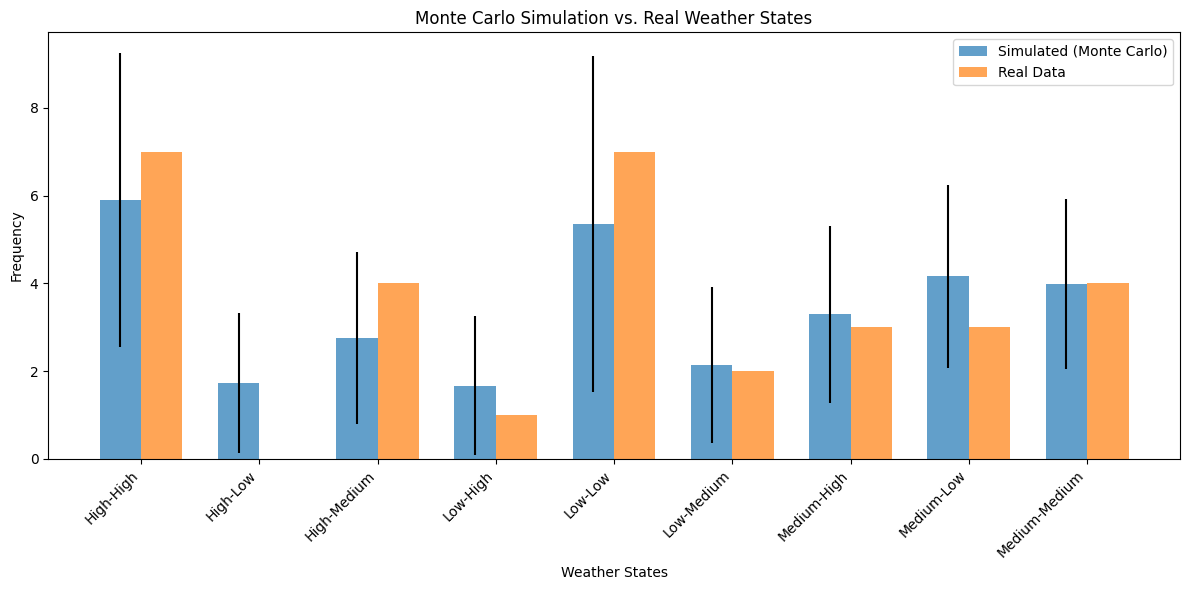

In [ ]:

# Run Monte Carlo simulation
mc_results = monte_carlo_markov_chain(
    transition_matrix=transition_matrix,
    states=all_states, 
    steps=30,  # for January
    n_simulations=1000, 
)

# Analyze results
analysis = analyze_monte_carlo_results(
    mc_results=mc_results,
    real_data=state_counts_test, 
    states=all_states,
    test_sequence= state_sequence_test
)

## Constrained Markov Chain - k-Day Constraint 

In [72]:
def implement_k_exact_consecutive_days_constraint(transition_matrix, states, target_state, k, boost_factor=2.0):
    """
    Modify transition matrix to encourage exactly k consecutive occurrences of target_state

    Args:
        transition_matrix: Original transition matrix (Pandas DataFrame)
        states: List of possible states
        target_state: The state that must appear in exactly k consecutive days
        k: Number of consecutive days required
        boost_factor: Factor to increase transition probabilities

    Returns:
        Modified transition matrix
    """
    # Create a copy of the transition matrix
    modified_matrix = transition_matrix.copy()

    # 1. Boost transitions TO the target state from all other states
    for state in states:
        if state != target_state:
            # Get current probability of transitioning to target state
            current_prob = modified_matrix.loc[state, target_state]

            # Calculate boost amount
            boost = current_prob * (boost_factor - 1)

            # Add boost to target state transition
            modified_matrix.loc[state, target_state] += boost

            # Reduce other probabilities proportionally
            other_states = [s for s in states if s != target_state]
            other_probs_sum = modified_matrix.loc[state, other_states].sum()

            if other_probs_sum > 0:  # Avoid division by zero
                reduction_factor = (other_probs_sum - boost) / other_probs_sum
                for other_state in other_states:
                    modified_matrix.loc[state, other_state] *= reduction_factor

    # 2. Boost SELF-transition for target state to keep it for k-1 more times
    # but then ensure it transitions away after exactly k occurrences
    current_self_prob = modified_matrix.loc[target_state, target_state]

    # For exactly k occurrences, we want:
    # - High self-transition probability for the first k-1 transitions
    # - Then ensure transition away on the kth occurrence
    # This can't be fully captured in the transition matrix alone since it's state-based
    # So we do our best approximation in the matrix, and handle exact counts during sequence generation

    # For first k-1 transitions, boost self-transition
    min_prob = 0.8  # Higher probability to stay in state for k-1 times

    if current_self_prob < min_prob:
        boost = min_prob - current_self_prob

        # Set self-transition to higher probability
        modified_matrix.loc[target_state, target_state] = min_prob

        # Reduce other probabilities from target state proportionally
        other_states = [s for s in states if s != target_state]
        other_probs_sum = modified_matrix.loc[target_state, other_states].sum()

        if other_probs_sum > 0:  # Avoid division by zero
            reduction_factor = (other_probs_sum - boost) / other_probs_sum
            for other_state in other_states:
                modified_matrix.loc[target_state, other_state] *= reduction_factor

    # Ensure rows still sum to 1 (handle numerical precision issues)
    for state in states:
        row_sum = modified_matrix.loc[state].sum()
        if abs(row_sum - 1.0) > 1e-10:  # If not very close to 1
            modified_matrix.loc[state] /= row_sum

    return modified_matrix

In [73]:

def generate_k_exact_consecutive_days_sequence(transition_matrix, states, target_state, k, 
                                             initial_state=None, steps=31, max_attempts=100):
    """
    Generate a sequence with exactly k consecutive occurrences of target_state (no more, no less)
    
    Args:
        transition_matrix: Your transition probability matrix (Pandas DataFrame)
        states: List of possible states
        target_state: State that must appear in exactly k consecutive days
        k: Number of consecutive days required
        initial_state: Starting state (if None, will be randomly selected)
        steps: Number of days to generate
        max_attempts: Maximum number of attempts to generate sequence with constraint
        
    Returns:
        A sequence that contains exactly k consecutive occurrences of target_state
    """
    # Check if k is greater than the number of steps (impossible constraint)
    if k > steps:
        raise ValueError(f"Cannot have {k} consecutive days in a sequence of {steps} days")
    
    # First approach: Try to generate sequences that naturally satisfy the constraint
    for attempt in range(max_attempts):
        # Modify transition matrix with increasing boost factor as needed
        boost_factor = 1.5
        modified_matrix = implement_k_exact_consecutive_days_constraint(
            transition_matrix, states, target_state, k, boost_factor)
        
        # If no initial state is provided, select one randomly
        if initial_state is None:
            initial_state = np.random.choice(states)
            
        # Generate sequence with modified matrix
        sequence = simulate_markov_chain(modified_matrix, states, initial_state, steps)
        
        # Check for exactly k consecutive occurrences
        # Find all runs of the target state
        runs = []
        current_run = 0
        
        for state in sequence:
            if state == target_state:
                current_run += 1
            else:
                if current_run > 0:
                    runs.append(current_run)
                    current_run = 0
        
        # Add the last run if there is one
        if current_run > 0:
            runs.append(current_run)
        
        # Check if there's a run of exactly k
        if k in runs:
            return sequence
    
    # If we've exhausted attempts, use direct insertion to guarantee constraint
    print(f"Warning: Could not generate sequence naturally after {max_attempts} attempts.")
    print("Using direct insertion method to guarantee constraint.")
    
    # Start with unconstrained sequence
    if initial_state is None:
        initial_state = np.random.choice(states)
    base_sequence = simulate_markov_chain(transition_matrix, states, initial_state, steps)
    
    # First ensure there are no runs of the target state longer than k-1
    # Break up any longer runs
    i = 0
    while i < len(base_sequence) - (k-1):
        # Check if we have a run longer than k-1
        is_long_run = True
        for j in range(k):
            if i+j >= len(base_sequence) or base_sequence[i+j] != target_state:
                is_long_run = False
                break
        
        # If we found a run of k or longer, break it up at position k
        if is_long_run:
            # Find a different state to insert
            other_states = [s for s in states if s != target_state]
            replacement_state = np.random.choice(other_states)
            base_sequence[i+k-1] = replacement_state
        
        i += 1
    
    # Now find a spot to insert exactly k consecutive occurrences
    max_start_position = len(base_sequence) - k
    insert_position = np.random.randint(0, max_start_position + 1)
    
    # Insert k consecutive target states
    for i in range(k):
        base_sequence[insert_position + i] = target_state
    
    # Verify the sequence has exactly one run of k consecutive occurrences
    runs = []
    current_run = 0
    
    for state in base_sequence:
        if state == target_state:
            current_run += 1
        else:
            if current_run > 0:
                runs.append(current_run)
                current_run = 0
    
    # Add the last run if there is one
    if current_run > 0:
        runs.append(current_run)
    
    # Double-check we have exactly one run of k
    k_count = runs.count(k)
    if k_count != 1:
        # This should not happen, but just in case, fix it
        print(f"Warning: After direct insertion, found {k_count} runs of exactly {k} consecutive days")
        print("Attempting to fix sequence...")
        
        # Start over with a new sequence
        return generate_k_exact_consecutive_days_sequence(
            transition_matrix, states, target_state, k, initial_state, steps)
    
    return base_sequence

In [74]:
def monte_carlo_with_k_exact_consecutive_days_constraint(transition_matrix, states, target_state, k,
                                                      initial_state=None, steps=31, n_simulations=1000):
    """
    Performs Monte Carlo simulation of a Markov Chain with exactly k consecutive days constraint
    
    Args:
        transition_matrix: Pandas DataFrame with states as indices and columns
        states: List of possible states
        target_state: State that must appear exactly k consecutive times
        k: Number of consecutive days required
        initial_state: Starting state (if None, will be randomly chosen)
        steps: Number of steps to simulate in each run
        n_simulations: Number of simulations to run
        
    Returns:
        Dictionary containing:
        - 'mean_counts': Average count of each state across all simulations
        - 'std_counts': Standard deviation of counts for each state
        - 'ci_lower', 'ci_upper': 95% confidence intervals for state frequencies
        - 'all_sequences': List of all simulated sequences
        - 'run_distributions': Distribution of run lengths
    """
    # Initialize storage for all simulations
    all_sequences = []
    all_counts = {state: [] for state in states}
    run_distributions = {i: 0 for i in range(1, k+2)}  # Track runs of 1, 2, ..., k, k+1 or more
    
    # Run n_simulations
    for i in range(n_simulations):
        if i % 100 == 0 and i > 0:
            print(f"Completed {i}/{n_simulations} simulations...")
            
        # Generate sequence with constraint
        sequence = generate_k_exact_consecutive_days_sequence(
            transition_matrix, states, target_state, k, initial_state, steps)
        all_sequences.append(sequence)
        
        # Count occurrences of each state in this simulation
        counts = Counter(sequence)
        for state in states:
            all_counts[state].append(counts.get(state, 0))
            
        # Analyze run lengths
        runs = []
        current_run = 0
        
        for state in sequence:
            if state == target_state:
                current_run += 1
            else:
                if current_run > 0:
                    runs.append(current_run)
                    current_run = 0
        
        # Add the last run if there is one
        if current_run > 0:
            runs.append(current_run)
        
        # Update run distribution
        for run_length in runs:
            if run_length <= k:
                run_distributions[run_length] += 1
            else:
                run_distributions[k+1] += 1  # k+1 bucket counts runs longer than k
    
    # Calculate statistics
    mean_counts = {state: np.mean(counts) for state, counts in all_counts.items()}
    std_counts = {state: np.std(counts) for state, counts in all_counts.items()}
    
    # Calculate 95% confidence intervals
    ci_lower = {state: np.percentile(counts, 2.5) for state, counts in all_counts.items()}
    ci_upper = {state: np.percentile(counts, 97.5) for state, counts in all_counts.items()}
    
    return {
        'mean_counts': mean_counts,
        'std_counts': std_counts,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'all_sequences': all_sequences,
        'run_distributions': run_distributions
    }

In [75]:

def analyze_k_exact_consecutive_days_constraint_effect(transition_matrix, states, target_state, k, 
                                                    real_data=None, n_simulations=1000, steps=31):
    """
    Analyze the effect of the exactly k consecutive days constraint
    
    Args:
        transition_matrix: Pandas DataFrame with states as indices and columns
        states: List of possible states  
        target_state: State that must appear exactly k consecutive times
        k: Number of consecutive days required
        real_data: Optional dictionary or Counter with actual observed frequencies
        n_simulations: Number of simulations to run
        steps: Number of steps to simulate in each run
        
    Returns:
        Dictionary with analysis metrics
    """
    # Run Monte Carlo simulations
    print(f"Running Monte Carlo simulation with exactly {k} consecutive days constraint for state '{target_state}'...")
    constrained_results = monte_carlo_with_k_exact_consecutive_days_constraint(
        transition_matrix, states, target_state, k, steps=steps, n_simulations=n_simulations)
    
    print(f"Running Monte Carlo simulation without constraints for comparison...")
    unconstrained_results = monte_carlo_markov_chain(
        transition_matrix, states, steps=steps, n_simulations=n_simulations)
    
    # Extract statistical results
    constrained_means = constrained_results['mean_counts']
    constrained_stds = constrained_results['std_counts']
    
    unconstrained_means = unconstrained_results['mean_counts']
    unconstrained_stds = unconstrained_results['std_counts']
    
    # Prepare data for visualization (state comparison)
    plt.figure(figsize=(12, 6))
    x = np.arange(len(states))
    width = 0.35
    
    # Set means for visualization
    vis_const_means = [constrained_means.get(state, 0) for state in states]
    vis_unconst_means = [unconstrained_means.get(state, 0) for state in states]
    
    # Set standard deviations for error bars
    vis_const_stds = [constrained_stds.get(state, 0) for state in states]
    vis_unconst_stds = [unconstrained_stds.get(state, 0) for state in states]
    
    # Create bar plot
    plt.bar(x - width/2, vis_unconst_means, width, yerr=vis_unconst_stds, 
            label='Unconstrained', alpha=0.7)
    plt.bar(x + width/2, vis_const_means, width, yerr=vis_const_stds, 
            label=f'Exactly {k} Consecutive Days ({target_state})', alpha=0.7)
    
    # Add real data if provided
    if real_data is not None:
        real_counts = [real_data.get(state, 0) for state in states]
        plt.plot(x, real_counts, 'ro', label='Real Data', markersize=8)
        
    # Format plot    
    plt.xlabel('Weather States')
    plt.ylabel('Frequency')
    plt.title(f'Effect of Exactly {k} Consecutive Days Constraint (Target: {target_state})')
    plt.xticks(x, states, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.savefig('k_exact_consecutive_days_analysis.png')
    
    # Visualize the distribution of run lengths
    run_dist = constrained_results['run_distributions']
    run_lengths = list(run_dist.keys())
    run_counts = list(run_dist.values())
    
    plt.figure(figsize=(10, 6))
    plt.bar(run_lengths, run_counts, alpha=0.7, edgecolor='black')
    plt.axvline(x=k, color='red', linestyle='--', label=f'Constraint Requirement (k={k})')
    plt.xlabel('Run Length (Consecutive Occurrences)')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Run Lengths for {target_state}')
    plt.xticks(run_lengths)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('k_exact_consecutive_days_run_distribution.png')
    
    # Calculate impact on target state frequency
    target_constrained = constrained_means.get(target_state, 0)
    target_unconstrained = unconstrained_means.get(target_state, 0)
    target_diff = target_constrained - target_unconstrained
    target_percent_change = (target_diff / target_unconstrained) * 100 if target_unconstrained > 0 else float('inf')
    
    # Calculate statistics
    # Prepare vectors for chi-square test
    const_vector = [constrained_means.get(state, 0) for state in states]
    unconst_vector = [unconstrained_means.get(state, 0) for state in states]
    
    # Run chi-square test
    chi2_stat, p_value = chisquare(const_vector, f_exp=unconst_vector)
    
    # Calculate mean absolute error between constrained and unconstrained
    mae = np.mean([abs(constrained_means.get(state, 0) - unconstrained_means.get(state, 0)) 
                  for state in states])
    
    # Calculate state impacts
    state_impacts = {}
    for state in states:
        diff = constrained_means[state] - unconstrained_means[state]
        state_impacts[state] = diff
    
    # Find states with largest changes
    sorted_impacts = sorted(state_impacts.items(), key=lambda x: abs(x[1]), reverse=True)
    
    # Check if the constraint was correctly enforced
    # Every sequence should have exactly one run of length k
    k_run_count = run_dist.get(k, 0)
    constraint_satisfaction_rate = (k_run_count / n_simulations) * 100
    
    # Print summary statistics
    print("\n=== Exactly K Consecutive Days Constraint Analysis Results ===")
    print(f"Target state: {target_state}")
    print(f"Required consecutive days (k): {k}")
    print(f"Constraint satisfaction: {constraint_satisfaction_rate:.1f}% of sequences have exactly one run of length {k}")
    
    print(f"\nTarget state frequency:")
    print(f"  Unconstrained: {target_unconstrained:.2f} days")
    print(f"  Constrained: {target_constrained:.2f} days")
    print(f"  Difference: {target_diff:+.2f} days ({target_percent_change:+.1f}%)")
    
    print(f"\nRun length distribution:")
    for run_length, count in sorted(run_dist.items()):
        if run_length <= k:
            print(f"  {run_length} consecutive days: {count} runs (across {n_simulations} sequences)")
        else:
            print(f"  {k+1}+ consecutive days: {count} runs (across {n_simulations} sequences)")
    
    print(f"\nChi-square test:")
    print(f"  Chi-square statistic: {chi2_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Distributions are {'not ' if p_value < 0.05 else ''}statistically similar")
    
    print(f"\nDifference metrics:")
    print(f"  Mean absolute error: {mae:.4f}")
    
    print(f"\nStates with largest changes in frequency:")
    for state, change in sorted_impacts[:3]:
        print(f"  {state}: {change:+.4f}")
    
    # Return comprehensive results
    return {
        'constrained_results': constrained_results,
        'unconstrained_results': unconstrained_results,
        'target_state': target_state,
        'k': k,
        'run_distributions': run_dist,
        'constraint_satisfaction_rate': constraint_satisfaction_rate,
        'state_impacts': state_impacts,
        'sorted_impacts': sorted_impacts,
        'chi2_stat': chi2_stat,
        'p_value': p_value,
        'mae': mae
    }

# Example function to test the implementation
def test_k_exact_consecutive_days_constraint(target_state='High-High', k=3):
    """
    Test the exactly k consecutive days constraint with a single sequence
    """
    # Generate a sequence with the constraint
    constrained_sequence = generate_k_exact_consecutive_days_sequence(
        transition_matrix=transition_matrix, 
        states=all_states, 
        target_state=target_state, 
        k=k, 
        steps=31)
    
    # Check if constraint is satisfied - look for runs of exactly k
    runs = []
    current_run = 0
    
    for state in constrained_sequence:
        if state == target_state:
            current_run += 1
        else:
            if current_run > 0:
                runs.append(current_run)
                current_run = 0
    
    # Add the last run if there is one
    if current_run > 0:
        runs.append(current_run)
    
    # Count runs of exactly k
    k_runs = runs.count(k)
    
    # Check if there are runs longer than k
    longer_runs = sum(1 for run in runs if run > k)
    
    # Count occurrences
    occurrences = constrained_sequence.count(target_state)
    
    print(f"Target state: {target_state}")
    print(f"Required consecutive days (k): {k}")
    print(f"Runs of target state: {runs}")
    print(f"Runs of exactly {k} consecutive days: {k_runs}")
    print(f"Runs longer than {k} consecutive days: {longer_runs}")
    print(f"Total occurrences: {occurrences}")
    print(f"Generated sequence: {constrained_sequence}")
    
    return constrained_sequence

In [76]:
# For Monte Carlo analysis
def test_k_exact_consecutive_days_constraint_monte_carlo(target_state='High-High', k=3):
    """
    Test the exactly k consecutive days constraint with Monte Carlo simulation
    """
    # Select a target state and k value
    target_state = 'High-High'  # State that should appear exactly k consecutive times
    k = 3  # Number of consecutive days required
    
    # Run the analysis
    analysis_results = analyze_k_exact_consecutive_days_constraint_effect(
        transition_matrix=transition_matrix,
        states=all_states,
        target_state=target_state,
        k=k,
        real_data=state_counts_test,  # Optional: your real January 2025 data if available
        n_simulations=1000,
        steps=31
    )
    
    print("\nMonte Carlo analysis of exactly k consecutive days constraint completed!")
    return analysis_results

Running Monte Carlo simulation with exactly 3 consecutive days constraint for state 'High-High'...
Completed 100/1000 simulations...
Completed 200/1000 simulations...
Completed 300/1000 simulations...
Completed 400/1000 simulations...
Completed 500/1000 simulations...
Completed 600/1000 simulations...
Completed 700/1000 simulations...
Completed 800/1000 simulations...
Completed 900/1000 simulations...
Running Monte Carlo simulation without constraints for comparison...

=== Exactly K Consecutive Days Constraint Analysis Results ===
Target state: High-High
Required consecutive days (k): 3
Constraint satisfaction: 124.7% of sequences have exactly one run of length 3

Target state frequency:
  Unconstrained: 5.64 days
  Constrained: 15.36 days
  Difference: +9.71 days (+172.0%)

Run length distribution:
  1 consecutive days: 816 runs (across 1000 sequences)
  2 consecutive days: 564 runs (across 1000 sequences)
  3 consecutive days: 1247 runs (across 1000 sequences)
  4+ consecutive days:

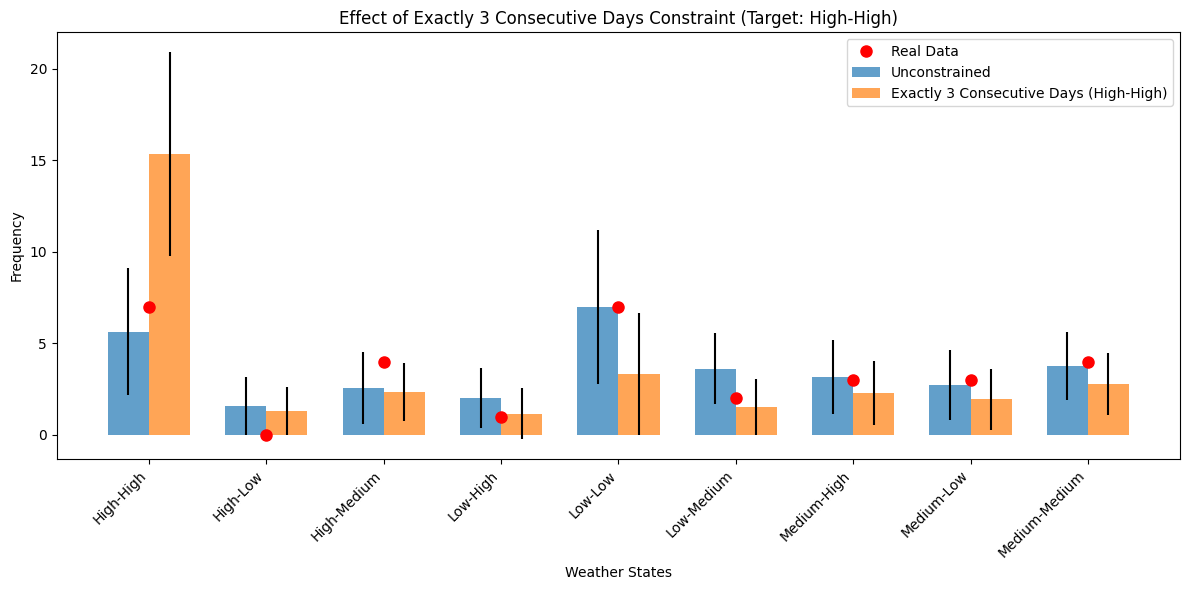

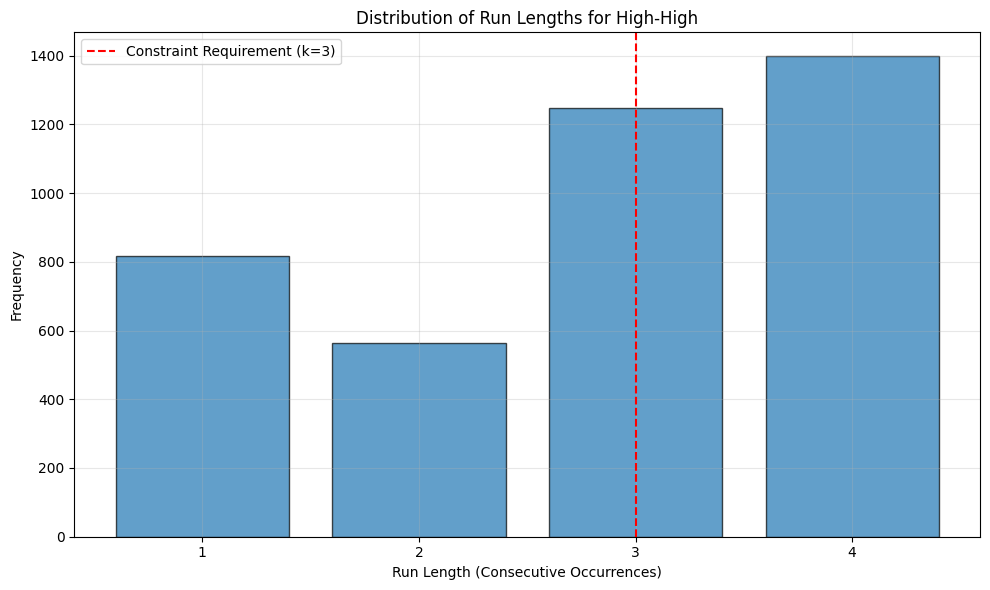

In [77]:
k_day_sim = test_k_exact_consecutive_days_constraint_monte_carlo()

In [ ]:
# get 5 random sequences from monte carlo simulation 
constrained_sequences = k_day_sim['constrained_results']['all_sequences']
random_sequences = random.sample(constrained_sequences, 5)

In [47]:
random_sequences

[['Low-Low',
  'High-High',
  'Medium-Medium',
  'Medium-High',
  'Medium-High',
  'Medium-Medium',
  'Low-High',
  'Low-Low',
  'Low-High',
  'Low-Low',
  'Low-High',
  'Low-High',
  'Medium-High',
  'Medium-Medium',
  'Medium-High',
  'High-High',
  'Medium-Medium',
  'Low-Medium',
  'Low-High',
  'Medium-Low',
  'High-High',
  'High-High',
  'High-High',
  'High-High',
  'High-Medium',
  'High-High',
  'High-High',
  'High-High',
  'Medium-Medium',
  'High-High',
  'High-High',
  'High-High'],
 ['Medium-Medium',
  'Low-Low',
  'Low-Low',
  'Low-Low',
  'Low-Low',
  'Low-Low',
  'Low-Low',
  'Low-Low',
  'Low-Low',
  'Medium-High',
  'Medium-Low',
  'High-High',
  'High-High',
  'High-High',
  'High-High',
  'High-High',
  'High-Low',
  'High-High',
  'Medium-Medium',
  'High-High',
  'High-High',
  'High-High',
  'High-High',
  'High-High',
  'High-Low',
  'High-Medium',
  'High-High',
  'Medium-High',
  'Medium-High',
  'High-High',
  'High-High',
  'High-High'],
 ['High-Medium',
 

In [34]:
def seq_heatmap(random_sequences, state_sequence_test ): 
    # Define all possible state labels (make sure it's the full set from your data)
    all_labels = sorted(set([
        "High-High", "High-Medium", "High-Low",
        "Medium-High", "Medium-Medium", "Medium-Low",
        "Low-High", "Low-Medium", "Low-Low"
    ]))

    # Convert all to np.str_ to match your data if needed
    all_labels = list(map(np.str_, all_labels))

    # Convert test sequence counts to a row
    test_counts = Counter(state_sequence_test)
    test_row = [test_counts.get(label, 0) for label in all_labels]

    # Collect counts from generated sequences
    rows = []
    labels = []

    for i, seq in enumerate(random_sequences):
        seq_counts = Counter(seq)
        row = [seq_counts.get(label, 0) for label in all_labels]
        rows.append(row)
        labels.append(f"Generated {i+1}")

    # Add test row
    rows.append(test_row)
    labels.append("Test")

    # Convert to DataFrame
    df = pd.DataFrame(rows, columns=all_labels, index=labels)

    # Plot heatmap
    plt.figure(figsize=(14, 7))
    sns.heatmap(df, annot=True, cmap="YlGnBu", fmt="d", cbar_kws={"label": "Frequency"})
    plt.title("Frequency of Weather States in No Day Constrained Generated vs Test Sequences", size =18 )
    plt.ylabel("Sequence", size = 14)
    plt.xlabel("State Label", size =14)
    plt.tight_layout()
    plt.show()
    

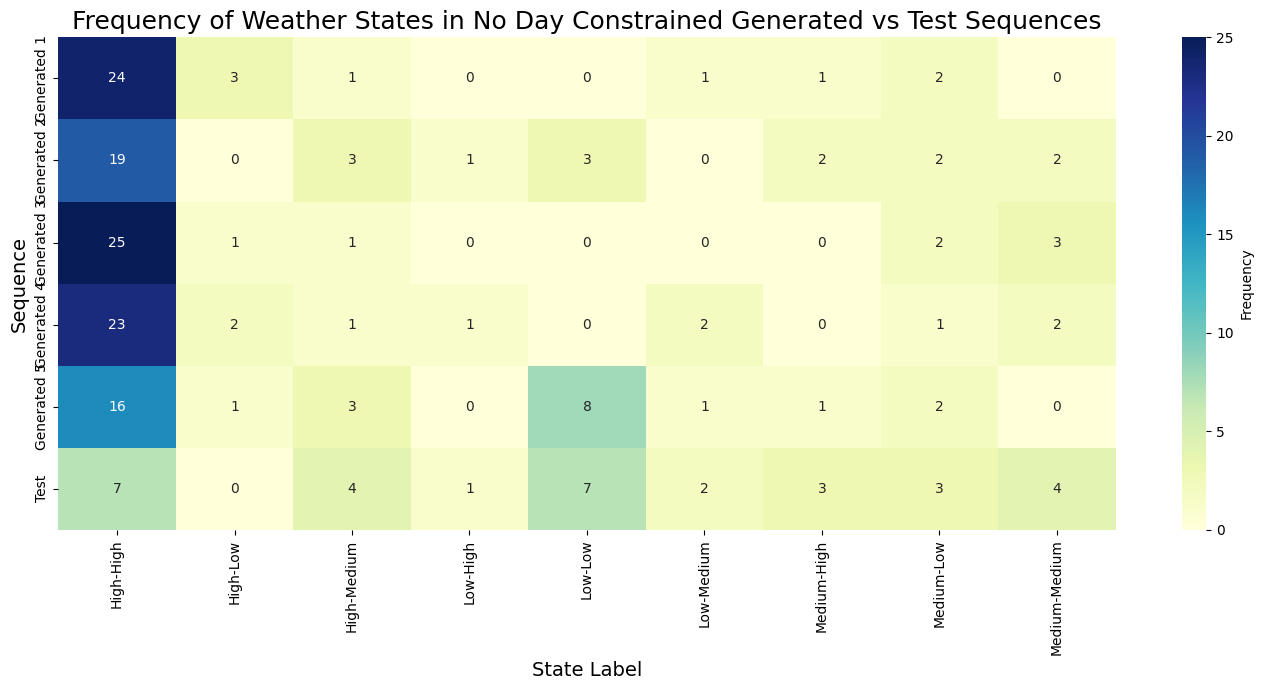

In [35]:
seq_heatmap(random_sequences, state_sequence_test)

In [36]:
def sequence_line_plot(random_sequences, weather_var):
    plt.figure(figsize=(14, 7))

    # Plot the actual (test) sequence
    days = daily_mean_test_df['day']
    plt.plot(days, daily_mean_test_df[weather_var], marker='o', label=f'Test {weather_var.capitalize()}', color='blue', linewidth=2)

    # For each generated sequence
    for idx, gen in enumerate(random_sequences):
        temperature_gen1, precipitation_gen1 = zip(*[str(state).split('-') for state in gen])
        prec_val_gen1 = []
        temp_val_gen1 = []

        for i in temperature_gen1: 
            if i == 'Low': 
                temp_val_gen1.append(float(random.choice(temp_low1)))
            elif i == 'Medium': 
                temp_val_gen1.append(float(random.choice(temp_med1)))
            elif i == 'High': 
                temp_val_gen1.append(float(random.choice(temp_high1)))

        for i in precipitation_gen1: 
            if i == 'Low': 
                prec_val_gen1.append(float(random.choice(prec_low1)))
            elif i == 'Medium': 
                prec_val_gen1.append(float(random.choice(prec_med1)))
            elif i == 'High': 
                prec_val_gen1.append(float(random.choice(prec_high1)))

        df_gen = pd.DataFrame({
            'temp': temp_val_gen1,
            'precip': prec_val_gen1
        })
        df_gen.index = df_gen.index + 1  # match day index

        # Plot the selected variable (temperature or precipitation)
        plt.plot(df_gen.index, df_gen[weather_var], marker='o', label=f'Generated #{idx+1}', alpha=0.6)

    # Dynamic label and title based on variable
    y_label = 'Temperature (°C)' if weather_var == 'temp' else 'Precipitation (mm)'
    title_var = 'Temperature' if weather_var == 'temp' else 'Precipitation'

    plt.xlabel('Day of January', size=18)
    plt.ylabel(y_label, size=18)
    plt.title(f'Average Daily {title_var}: Test vs Generated Sequences (k-Day Constraint)', size=26)
    plt.grid(True)
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.show()

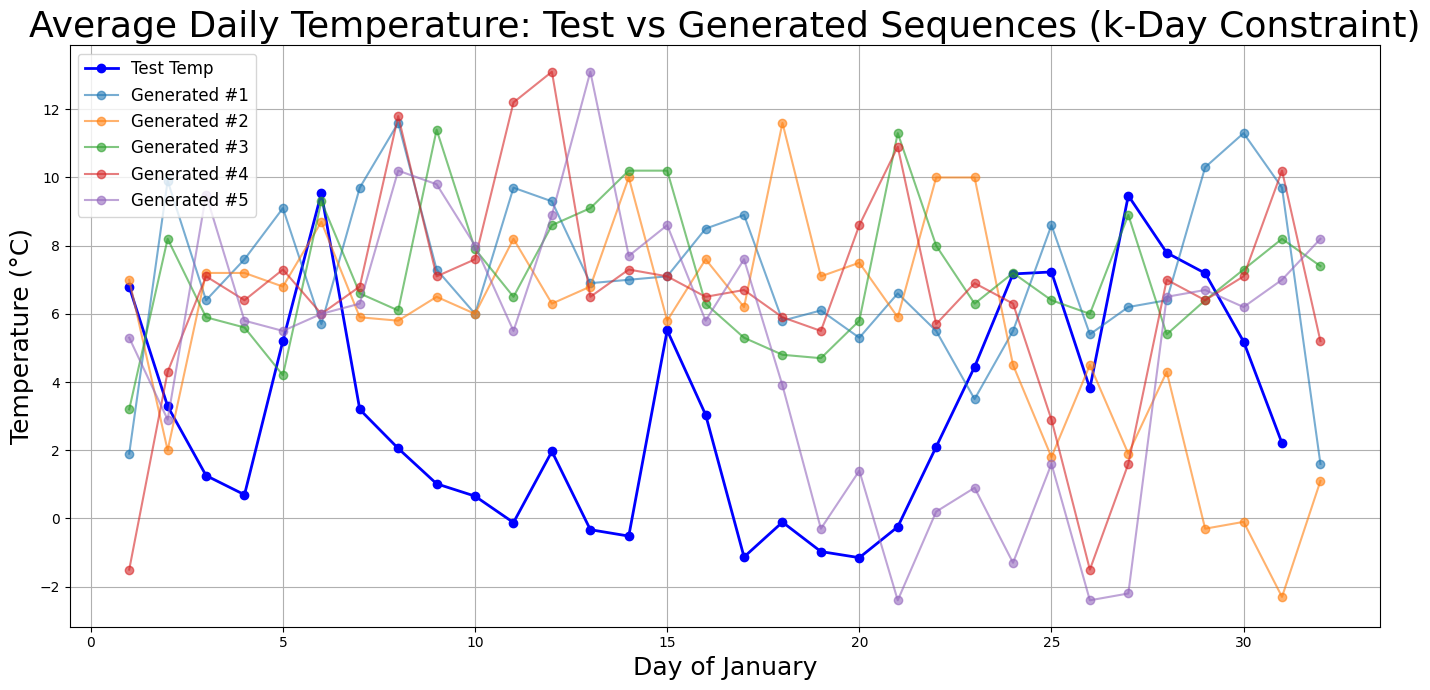

In [37]:
sequence_line_plot(random_sequences, 'temp')

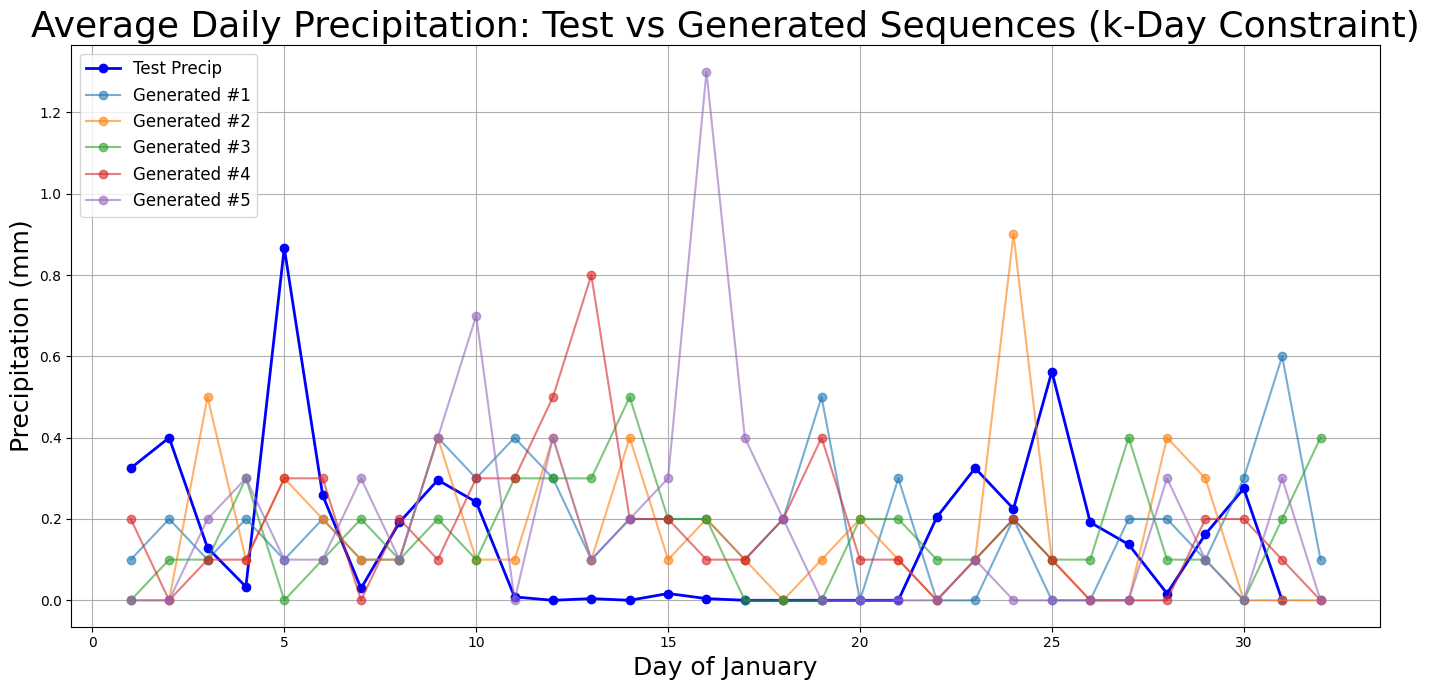

In [38]:
sequence_line_plot(random_sequences, 'precip')